In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pandas as pd
import seaborn as sns
import re

from collections import OrderedDict
from time import time
import sqlite3       

from sklearn.preprocessing import StandardScaler
from scipy.linalg import svd   
from scipy import stats
from sklearn.decomposition import TruncatedSVD

from sklearn.manifold import TSNE

import warnings
warnings.filterwarnings('ignore')

from IPython.html.widgets import interactive, fixed

sns.set(style="darkgrid", palette="muted")
pd.set_option('display.mpl_style', 'default')
pd.set_option('display.notebook_repr_html', True)
plt.rcParams['figure.figsize'] = 10,6
np.random.seed(0)

OptionError: "No such keys(s): 'display.mpl_style'"

In [2]:
cnx = sqlite3.connect('RECs_data/recs2015_public.db')

In [3]:
def scatter_3D(A, elevation=30, azimuth=120):
    
    maxpts=1000
    fig = plt.figure(1, figsize=(9, 9))
    ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=elevation, azim=azimuth)
    ax.set_xlabel('component 0')
    ax.set_ylabel('component 1')
    ax.set_zlabel('component 2')

    # plot subset of points
    rndpts = np.sort(np.random.choice(A.shape[0], min(maxpts,A.shape[0]), replace=False))
    coloridx = np.unique(A.iloc[rndpts]['TYPEHUQ'], return_inverse=True)
    colors = coloridx[1] / len(coloridx[0])   
    
    sp = ax.scatter(A.iloc[rndpts,0], A.iloc[rndpts,1], A.iloc[rndpts,2]
               ,c=colors, cmap="jet", marker='o', alpha=0.6
               ,s=50, linewidths=0.8, edgecolor='#BBBBBB')

    plt.show()

In [4]:
df_raw = pd.read_csv('RECs_data/recs2015_public.csv')
print(df_raw.shape)
df_raw.head()

(12083, 931)


,DOEID,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,1,2,4,12,2,2471.679705,4742,1080,4953,1271,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,2,4,10,26,2,8599.172010,2662,199,2688,143,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,3,1,1,1,5,8969.915921,6233,505,5741,829,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,4,2,3,7,2,18003.639600,6034,672,5781,868,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,5,1,1,1,3,5999.605242,5388,702,5313,797,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [5]:
Discarded_feature = [x for x in df_raw.columns if x.startswith('Z')] 
df = df_raw[[c for c in df_raw.columns.values.tolist() if c not in Discarded_feature]]
df.shape

(12083, 572)

In [6]:
df.to_sql('df_clean', cnx, if_exists='replace', index=None)

In [7]:
df = pd.read_sql('select * from df_clean', cnx)

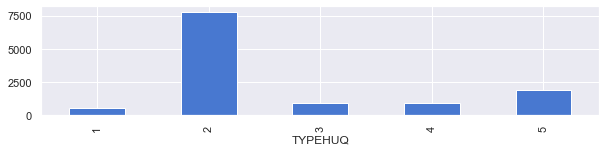

In [8]:
ax = df.groupby('TYPEHUQ').size().plot(kind='bar', figsize=(10,2))

In [9]:
basic = ['HDD65','CDD65','WALLTYPE','BEDROOMS','TOTROOMS','STOVEN','STOVEFUEL','AMTMICRO','AGERFRI1','ESFRIG',
         'HEATHOME','EQUIPAGE','AUTOHEATNITE','AUTOHEATDAY','TEMPGONE','BTUNGSPH','TOTALBTUCOL',
         'NHSLDMEM','EMPLOYHH','AGEAUD','WINDOWS']

idxdict = OrderedDict()
for b in basic:
    idxdict[b]=[b]

In [10]:
def plot_raw_vals(df, k):
    v = idxdict[k]
    dfg = pd.concat((df[['TYPEHUQ']],df[v]), axis=1)
    ax = dfg.boxplot(by='TYPEHUQ', layout=(2,4), figsize=(10,6)
                    ,showfliers=False, showmeans=True, rot=90)

interactive(plot_raw_vals, df=fixed(df), k=basic)

interactive(children=(Dropdown(description='k', options=('HDD65', 'CDD65', 'WALLTYPE', 'BEDROOMS', 'TOTROOMS',…

In [11]:
del df['METROMICRO']
del df['UR']
del df['DOEID']

#Replacing NaN values in the dataset with 0 so that the standardization and normalization functions do not choke
df.fillna(0,inplace=True)

In [12]:
for c in df.columns:
    df_new = df[np.abs(df[c]-df[c].mean())<=(3*df[c].std())]
df_new.head()

,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,2,4,12,2,2471.679705,4742,1080,4953,1271,4,...,0,-2,-2,-2,-2,-2,-2,-2,-2,-2
1,4,10,26,2,8599.172010,2662,199,2688,143,5,...,0,1,1,0,-2,-2,-2,-2,-2,-2
2,1,1,1,5,8969.915921,6233,505,5741,829,1,...,0,3,5,3,-2,-2,-2,-2,-2,-2
3,2,3,7,2,18003.639600,6034,672,5781,868,1,...,3,3,5,3,-2,-2,-2,-2,-2,-2
4,1,1,1,3,5999.605242,5388,702,5313,797,1,...,0,1,1,0,-2,-2,-2,-2,-2,-2


In [13]:
df_normalized=df
colNum=1
totalCols=len(df.columns)
for col in df.columns:
    minOfCol=df[col].min()
    maxOfCol=df[col].max()
    df_normalized[col]=(df_normalized[col]-minOfCol)/(maxOfCol-minOfCol)
    #print("Normalized column {} of {}".format(colNum,totalCols))
    colNum=colNum+1

In [14]:
df_normalized.head()
df.fillna(0,inplace=True) 
df_normalized.head()

,REGIONC,DIVISION,REPORTABLE_DOMAIN,TYPEHUQ,NWEIGHT,HDD65,CDD65,HDD30YR,CDD30YR,Climate_Region_Pub,...,SCALEEL,KAVALNG,PERIODNG,SCALENG,PERIODLP,SCALELP,PERIODFO,SCALEFO,PERIODKR,SCALEKER
0,0.333333,0.333333,0.423077,0.25,0.020939,0.378603,0.197080,0.371122,0.237260,0.75,...,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1.000000,1.000000,0.961538,0.25,0.085234,0.212535,0.036314,0.201409,0.026694,1.00,...,0.0,0.6,0.428571,0.4,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.000000,1.00,0.089124,0.497645,0.092153,0.430166,0.154751,0.00,...,0.0,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.333333,0.222222,0.230769,0.25,0.183914,0.481756,0.122628,0.433163,0.162031,0.00,...,1.0,1.0,1.000000,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.000000,0.50,0.057957,0.430180,0.128102,0.398097,0.148777,0.00,...,0.0,0.6,0.428571,0.4,0.0,0.0,0.0,0.0,0.0,0.0


In [15]:
u, s, vt = svd(df_normalized)

0 SVs are NaN
8 SVs are less than 1e-12


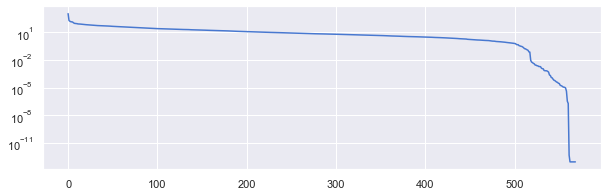

In [16]:
ax = pd.Series(s).plot(figsize=(10,3), logy=True)
print('{} SVs are NaN'.format(np.isnan(s).sum()))
print('{} SVs are less than 1e-12'.format(len(s[s< 1e-12])))

In [17]:
print(type(s))
np.size(s)

<class 'numpy.ndarray'>


569

In [18]:
idx = ~np.isnan(s)
xtrans = np.dot(u[:,idx], np.diag(s[idx]))
expvar = np.var(xtrans, axis=0)
fullvar = np.var(df_normalized, axis=0)
expvarrat = expvar/fullvar.sum()
ax = pd.Series(expvarrat.cumsum()).plot(kind='line', figsize=(10,3))
print('Variance preserved by first 300 components == {:.2%}'.format(expvarrat.cumsum()[300]))
print('Variance preserved by first 50 components == {:.2%}'.format(expvarrat.cumsum()[50]))

IndexError: boolean index did not match indexed array along dimension 1; dimension is 12083 but corresponding boolean dimension is 569

Variance preserved by first 300 components == 99.41%


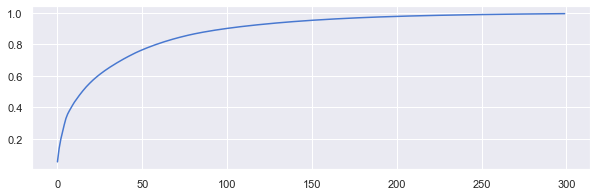

In [19]:
ncomps = 300
svd = TruncatedSVD(n_components=ncomps)
svd_fit = svd.fit(df_normalized)
Y = svd.fit_transform(df_normalized)
ax = pd.Series(svd_fit.explained_variance_ratio_.cumsum()).plot(kind='line', figsize=(10, 3))
print('Variance preserved by first 300 components == {:.2%}'.format(svd_fit.explained_variance_ratio_.cumsum()[-1]))

In [20]:
dfsvd = pd.DataFrame(Y, columns=['c{}'.format(c) for c in range(ncomps)], index=df.index)
print(dfsvd.shape)
dfsvd.head()

(12083, 300)


,c0,c1,c2,c3,c4,c5,c6,c7,c8,c9,...,c290,c291,c292,c293,c294,c295,c296,c297,c298,c299
0,10.948964,-2.553164,-1.320175,-0.332661,0.411241,-0.718791,-1.201730,0.928392,-1.340734,0.000100,...,0.047434,0.028895,-0.001685,-0.009533,0.016211,0.022392,0.010188,0.029592,-0.035514,0.021071
1,9.884151,0.755475,0.712976,-1.156621,-0.582364,-0.396438,1.278685,-0.521564,0.136853,-0.009553,...,0.024579,-0.023035,0.025095,0.009177,0.015540,0.000016,-0.029261,0.018049,-0.011395,-0.028131
2,7.234780,3.243273,1.911465,-1.155650,-0.881678,-0.965843,-1.188896,-0.130988,0.739985,-0.311060,...,-0.016366,-0.013800,-0.004707,0.029181,0.038558,-0.008481,-0.024103,0.022891,-0.017745,0.006355
3,10.251207,-1.116670,-0.160277,-1.019178,0.248752,0.372991,-0.089327,1.095080,0.206730,0.678957,...,-0.025790,0.000540,0.063153,0.013615,-0.085378,0.091543,0.031654,-0.066837,-0.105454,0.060274
4,9.003233,0.464212,1.791192,0.851937,-0.460342,-1.239563,-0.011559,-0.362750,-0.680125,1.381440,...,0.029206,-0.033965,0.009043,0.028166,0.017493,0.021297,0.023500,0.017772,0.016993,0.019024


In [21]:
dfsvd.to_sql('df_svd',cnx,if_exists='replace', index=None)

In [22]:
dfsvd = pd.read_sql('select * from df_svd', cnx)
svdcols = [c for c in dfsvd.columns if c[0] == 'c']

df = pd.read_sql('select * from df_clean', cnx)

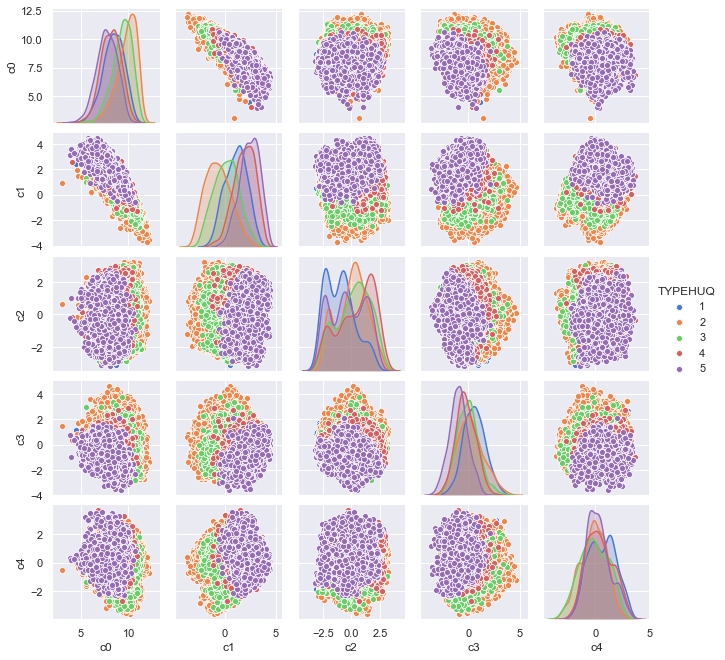

In [23]:
plotdims = 5
ploteorows = 1
dfsvdplot = dfsvd[svdcols].iloc[:,:plotdims]
dfsvdplot['TYPEHUQ']=df['TYPEHUQ']
ax = sns.pairplot(dfsvdplot.iloc[::ploteorows,:], hue='TYPEHUQ', size=1.8)

In [24]:
dfsvd['TYPEHUQ'] = df['TYPEHUQ']
interactive(scatter_3D, A=fixed(dfsvd), elevation=30, azimuth=120)

interactive(children=(IntSlider(value=30, description='elevation', max=90, min=-30), IntSlider(value=120, desc…

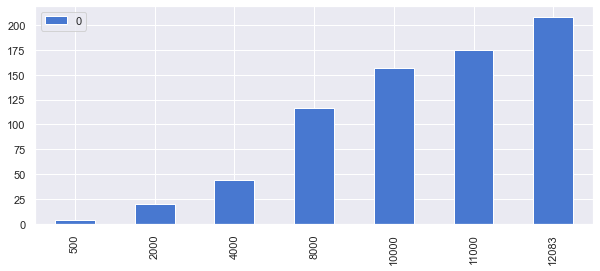

In [25]:
rowsubset = [500,2000,4000,8000,10000,11000,12083]
tsne = TSNE(n_components=2, random_state=0)
runs = np.empty((len(rowsubset),1))

for i, rows in enumerate(rowsubset):
    t0 = time()
    Z = tsne.fit_transform(dfsvd.iloc[:rows,:][svdcols])
    runs[i] = time() - t0

ax = pd.DataFrame(runs, index=rowsubset).plot(kind='bar', logy=False, figsize=(10,4))

In [26]:
Z = tsne.fit_transform(dfsvd[svdcols])
dftsne = pd.DataFrame(Z, columns=['x','y'], index=dfsvd.index)

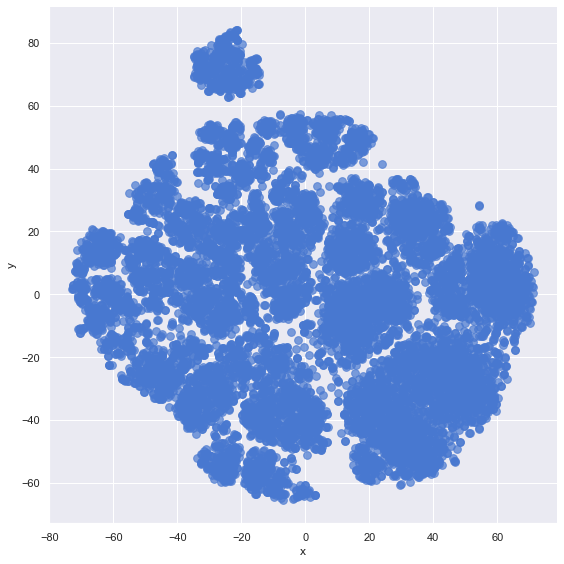

In [27]:
ax = sns.lmplot('x', 'y', dftsne, fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})

In [28]:
dftsne['TYPEHUQ'] = df['TYPEHUQ']

Text(0.5, 1.0, 'Scatterplot of a 300D dataset reduced to 2D using t-SNE')

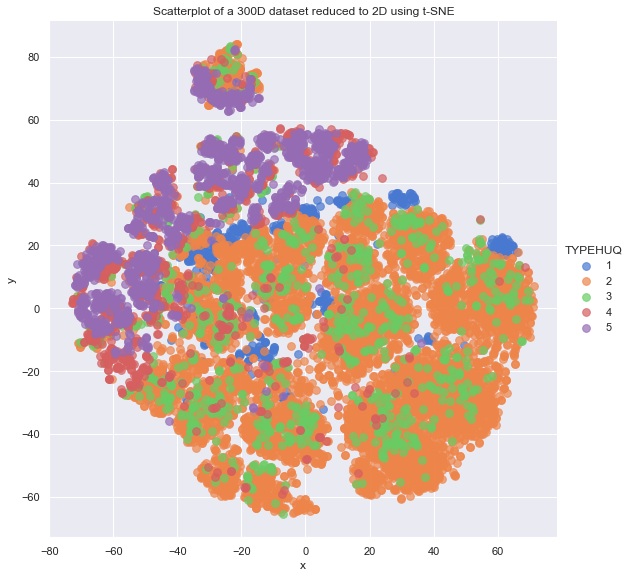

In [29]:
g = sns.lmplot('x', 'y', dftsne, hue='TYPEHUQ', fit_reg=False, size=8
                ,scatter_kws={'alpha':0.7,'s':60})
g.axes.flat[0].set_title('Scatterplot of a 300D dataset reduced to 2D using t-SNE')